In [1]:
!pip install -U jupyterlab==3.0.16
!pip install ipywidgets # --user
!pip install sklearn

In [2]:
import sys
sys.path.append('../../')

In [3]:
# imports
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import metrics
from ast import literal_eval
import torch
import torchvision
import torch.nn as nn
import itertools
import pickle as pkl

In [4]:
# define a function to get arrays from dataframe for model training
def get_data(df, cols):
    return df[cols].to_numpy(),df['distances'].to_numpy()

In [5]:
# define a function to update a dataframe w/ PCA reduced feature vectors
def get_vectors(data, n_components):
    df = data.copy()
    
    # transform the vectors to arrays
    fvs = df['feature_vector']
    fvs = np.stack(fvs, axis=0)
    
    # save off min/std arrays to use later
    np.save('fvs_min.npy', fvs.min(0))
    np.save('fvs_ptp.npy', fvs.ptp(0))
    
    # normalize the feature vectors
    fvs = (fvs - fvs.min(0)) / fvs.ptp(0)
    
    # perform pca reduction
    pca = PCA(n_components=n_components)
    fvs_reduced = pca.fit_transform(fvs)
    
    # save-off pca transform as pickel
    pkl.dump(pca, open("pca_transform.pkl", 'wb'))
    
    # update the dataframe
    new_cols = ['feature_vector_{}'.format(i) for i in range(fvs_reduced.shape[1])]
    df[new_cols] = fvs_reduced  
    return df

In [6]:
# create a dataset class
class NuScenesDataset(torch.utils.data.Dataset):
    def __init__(self, data, split='train', fvs=False, n_components=None):
        
        # read in the data
        self.data = data.copy()
        self.use_fvs = fvs
        
        # populate feature vectors into dataframe
        if self.use_fvs:
            self.data = get_vectors(self.data, n_components)
            
        # perform norm on the distances
        self.dist_min = self.data['distances'].min()
        self.dist_max = self.data['distances'].max()
        self.data['distances'] = self.data['distances'].apply(lambda x: 2*(x-self.dist_min)/(self.dist_max-self.dist_min) -1)
        
        # perform norm on the classes
        self.class_df = pd.get_dummies(self.data['classes'], prefix='class')
        self.data[self.class_df.columns] = self.class_df
        self.data.drop('classes', axis=1, inplace=True)
        
        # perform norm on the bboxes
        box_cols = [
            'boxes_xmin',
            'boxes_ymin',
            'boxes_xmax',
            'boxes_ymax'
        ]
        self.data[box_cols] = self.data[box_cols].apply(lambda x: x/1024.0, axis=1)
        
        # perform appropriate split of the data
        train_split = int(len(self.data) * 0.8)
        if split == 'train':
            self.data = self.data.iloc[0:train_split]
        else:
            self.data = self.data.iloc[train_split:]
            
        # create the data and targets
        self.columns = box_cols+self.class_df.columns.tolist()
        if self.use_fvs:
            self.columns += [col for col in self.data.columns.tolist() if 'feature_vector_' in col]
        self.inputs,self.targets = get_data(self.data, self.columns)
    
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        inputs,target = self.inputs[idx],self.targets[idx]
        return torch.tensor(inputs),torch.tensor(target)

In [7]:
# get our dataframes
train_data = pd.read_json('train.json')
test_data = pd.read_json('test.json')
data = pd.concat([train_data, test_data], axis=0)
data.reset_index(drop=True, inplace=True)

# construct our data
use_fvs = True
n_components = 12
train_dataset = NuScenesDataset(data, split='train', fvs=use_fvs, n_components=n_components)
test_dataset = NuScenesDataset(data, split='test', fvs=use_fvs, n_components=n_components)

# construct our data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False, drop_last=False)

In [8]:
# define our MLP model
class DistanceRegressor(nn.Module):
    def __init__(self, n_features):
        super(DistanceRegressor, self).__init__()
        
        # define our fully connected layers
        self.input = nn.Linear(n_features, 128)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 2048)
        self.output = nn.Linear(2048, 1)
        
        # define activation layers
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.input(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.output(x)
        x = self.activation(x)
        return x

In [9]:
# define our gpu device
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [10]:
# instantiate model
model = DistanceRegressor(n_features=33 if use_fvs else 12)
model.to(device)

DistanceRegressor(
  (input): Linear(in_features=24, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=2048, bias=True)
  (output): Linear(in_features=2048, out_features=1, bias=True)
  (activation): Tanh()
)

In [11]:
# hyper-params and optimizer
lr = 1e-5
wd = 1e-6
momentum = 0.9
delta = 1.75
n_epochs = 5
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)
criterion = nn.HuberLoss(delta=delta)

In [12]:
# train loop
train_losses = []
test_losses = []
test_metrics = []
best = None
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for i,(inputs, targets) in enumerate(trainloader):
        
        # bring data to gpu
        inputs,targets = inputs.to(device).float(),targets.to(device).float()
        
        # zero gradients
        optimizer.zero_grad()
        
        # forward pass
        preds = model(inputs)
        
        # loss and backprop
        loss = criterion(preds, targets.unsqueeze(1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/len(trainloader))
    
    # eval loop
    model.eval()
    with torch.no_grad():
        targets_list = []
        preds_list = []
        test_loss = 0
        for i,(inputs,targets) in enumerate(testloader):
            inputs,targets = inputs.to(device).float(),targets.to(device).float()
            preds = model(inputs)
            test_loss += criterion(preds, targets.unsqueeze(1)).item()
            
            targets_list.append(targets.cpu().numpy())
            preds_list.append(preds.flatten().cpu().numpy())
        
        # metrics calc
        test_losses.append(test_loss/len(testloader))
        
        targets_arr = np.concatenate(targets_list, axis=-1)
        preds_arr = np.concatenate(preds_list, axis=-1)
        
        targets_arr = (targets_arr+1)*(test_dataset.dist_max-test_dataset.dist_min)/2.0 + test_dataset.dist_min
        preds_arr = (preds_arr+1)*(test_dataset.dist_max-test_dataset.dist_min)/2.0 + test_dataset.dist_min
        
        rmse = metrics.rmse(preds_arr, targets_arr)
        test_metrics.append(rmse)
    
    # save off model weights
    if best is None:
        torch.save(model.state_dict(), 'fusion_mlp.pth')
        best = test_metrics[epoch]
    elif test_metrics[epoch] < best:
        torch.save(model.state_dict(), 'fusion_mlp.pth')
        best = test_metrics[epoch]

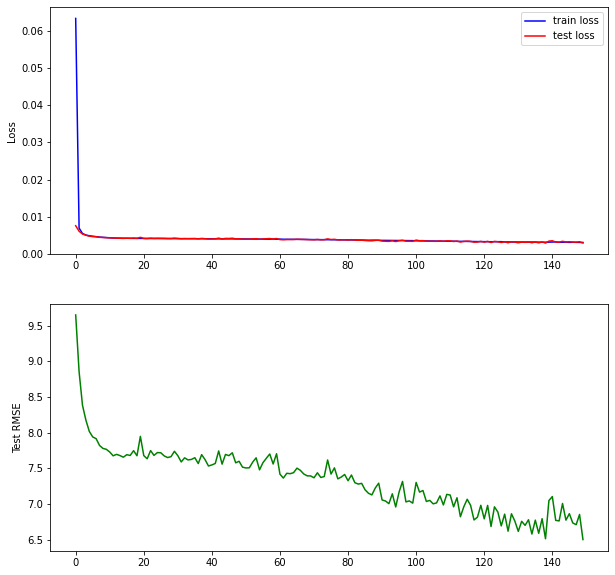

In [13]:
# plot losses and metrics
fig,ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(train_losses, c='b', label='train loss')
ax[0].set_ylabel('Loss')
ax[0].plot(test_losses, c='r', label='test loss')
ax[0].legend()
ax[1].plot(test_metrics, c='g')
ax[1].set_ylabel('Test RMSE')
plt.show()

In [14]:
# get predictions for best model
model.load_state_dict(torch.load('./fusion_mlp.pth'))
model.eval()
with torch.no_grad():
    targets_list = []
    preds_list = []
    for i,(inputs,targets) in enumerate(testloader):
        inputs,targets = inputs.to(device).float(),targets.to(device).float()
        preds = model(inputs)

        targets_list.append(targets.cpu().numpy())
        preds_list.append(preds.flatten().cpu().numpy())

    targets_arr = np.concatenate(targets_list, axis=-1)
    preds_arr = np.concatenate(preds_list, axis=-1)
    
    targets_arr = (targets_arr+1)*(test_dataset.dist_max-test_dataset.dist_min)/2.0 + test_dataset.dist_min
    preds_arr = (preds_arr+1)*(test_dataset.dist_max-test_dataset.dist_min)/2.0 + test_dataset.dist_min

    rmse = metrics.rmse(preds_arr, targets_arr)

In [15]:
abs_rel_dist = np.mean(metrics.abs_relative_distance(preds_arr, targets_arr))
sq_rel_dist = metrics.sq_relative_distance(preds_arr, targets_arr)
rmse = metrics.rmse(preds_arr, targets_arr)
print('Test Set Metrics')
print('----------------')
print('Abs Rel:{:.3f}'.format(abs_rel_dist))
print('Sq Rel: {:.3f}'.format(sq_rel_dist))
print('RMSE: {:.3f}'.format(rmse))

Test Set Metrics
----------------
Abs Rel:0.206
Sq Rel: 1.365
RMSE: 6.502


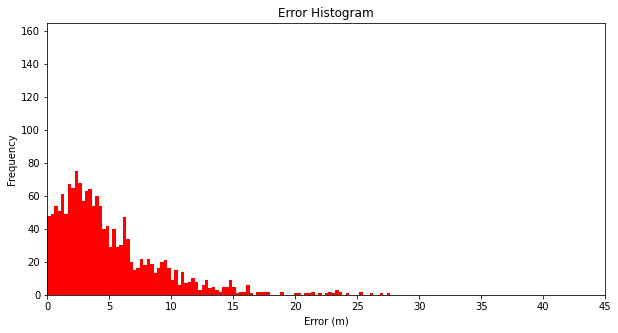

In [16]:
# plot an error histogram
abs_rel_errors = metrics.abs_relative_distance(preds_arr, targets_arr)
abs_rel_errors *= targets_arr
fig,ax = plt.subplots(1,1, figsize=(10,5))
ax.hist(abs_rel_errors, bins=100, color='r')
ax.set_title('Error Histogram')
ax.set_ylabel('Frequency')
ax.set_xlabel('Error (m)')
ax.set_xlim(0,45)
ax.set_ylim(0,165)
plt.show()

In [17]:
# bring in visual cnn dataset to help w/ mapping
from dataset import NuScenes
test_data = NuScenes(img_dir='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/',
                     meta_path='/irad_mounts/lambda-quad-5-data/beholder/nuscenes/nuscenes-v1.0-mini.csv',
                     transforms=None,
                     size=1024,
                     split='test')

IndexError: index 833 is out of bounds for axis 0 with size 10

In [18]:
# adjust predictions array to mapping of other visual-based cnn dataset
targets = []
preds = []
start = 0
for i in range(test_data.__len__()):
    data = test_data.__getitem__(i)
    _,_,_, classes = data
    
    n_obj = len(classes)
    
    d_t = targets_arr[start:start+n_obj]
    d_p = preds_arr[start:start+n_obj]
    targets.append(d_t)
    preds.append(d_p)
    
    start += n_obj

/run/determined/workdir/irad_users/fleisig/beholder-ml/notebooks/FeatureFusion/../../dataset.py:85: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = self.metadata.loc[self.sample_list[idx]]


In [19]:
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

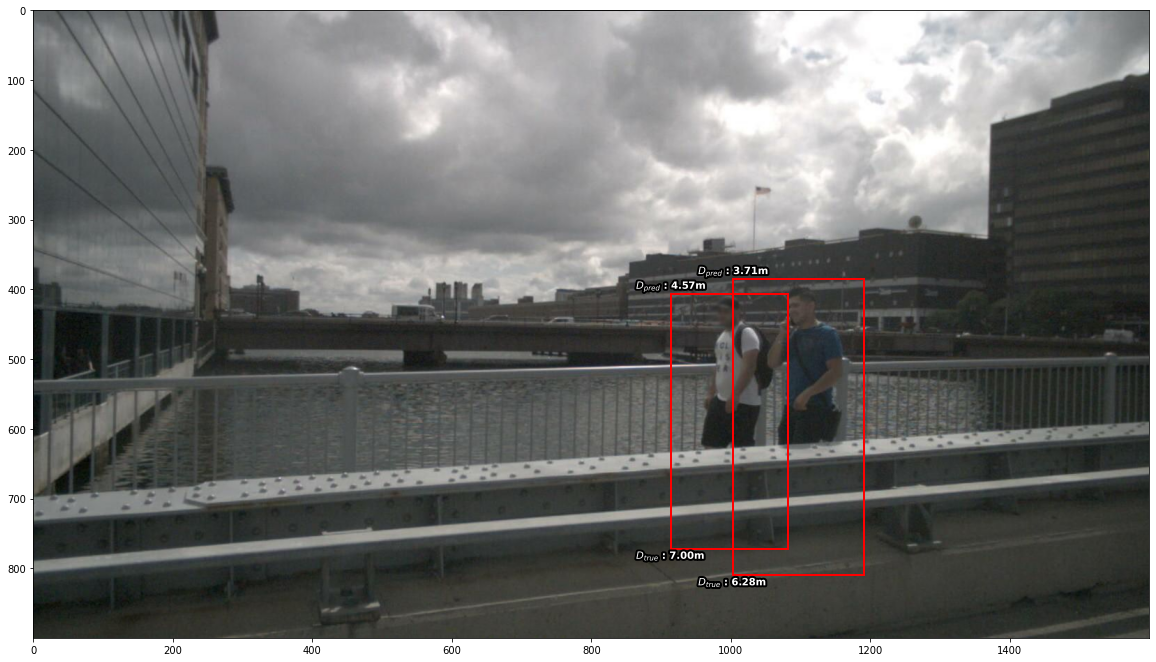

In [20]:
# show some results for an example
idx = 56
image,boxes,_,classes = test_data.__getitem__(idx)
distance_preds = preds[idx]
distance_targs = targets[idx]

fig,ax = plt.subplots(figsize=(20,16))
ax.imshow(image)
for i in range(len(boxes)):
    
    # get our ground truth and prediction labels/distances
    distance_pred = distance_preds[i]
    distance_true = distance_targs[i]
    
    rect = patches.Rectangle((boxes[i][0],boxes[i][3]),
                             boxes[i][2]-boxes[i][0],
                             boxes[i][1]-boxes[i][3],
                             linewidth=2,
                             edgecolor='r',
                             facecolor='none',
                             label='object')
    ax.add_patch(rect)
    ax.text(boxes[i][0]-50,
            boxes[i][1],
            '$D_{{pred}}$ : {:.2f}m'.format(distance_pred),
            verticalalignment='bottom',
            color='white',
            fontsize=10,
            weight='bold').set_path_effects([patheffects.Stroke(linewidth=4,
                                                                foreground='black'),
                                             patheffects.Normal()])
    ax.text(boxes[i][0]-50,
            boxes[i][3],
            '$D_{{true}}$ : {:.2f}m'.format(distance_true),
            verticalalignment='top',
            color='white',
            fontsize=10,
            weight='bold').set_path_effects([patheffects.Stroke(linewidth=4,
                                                                foreground='black'),
                                             patheffects.Normal()])
plt.show()